In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [16]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50 #no. of complete passes of the training set through the algo.

## Load data into tf.dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

* 'Potato___Early_blight' = 0
* 'Potato___Late_blight' = 1
* 'Potato___healthy' = 2

In [6]:
len(dataset) #this gives 68 because data are stored in batches 2152/32

68

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 1 1 0 2 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0]


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[186. 185. 193.]
  [191. 190. 198.]
  [190. 189. 197.]
  ...
  [148. 147. 153.]
  [144. 143. 149.]
  [140. 139. 145.]]

 [[178. 177. 185.]
  [163. 162. 170.]
  [181. 180. 188.]
  ...
  [144. 143. 149.]
  [145. 144. 150.]
  [149. 148. 154.]]

 [[184. 183. 191.]
  [194. 193. 201.]
  [204. 203. 211.]
  ...
  [141. 140. 146.]
  [147. 146. 152.]
  [158. 157. 163.]]

 ...

 [[182. 176. 180.]
  [183. 177. 181.]
  [184. 178. 182.]
  ...
  [156. 146. 145.]
  [163. 153. 152.]
  [151. 141. 140.]]

 [[185. 179. 183.]
  [188. 182. 186.]
  [190. 184. 188.]
  ...
  [137. 127. 126.]
  [139. 129. 128.]
  [131. 121. 120.]]

 [[180. 174. 178.]
  [184. 178. 182.]
  [187. 181. 185.]
  ...
  [137. 127. 126.]
  [149. 139. 138.]
  [158. 148. 147.]]]


## Data visualization

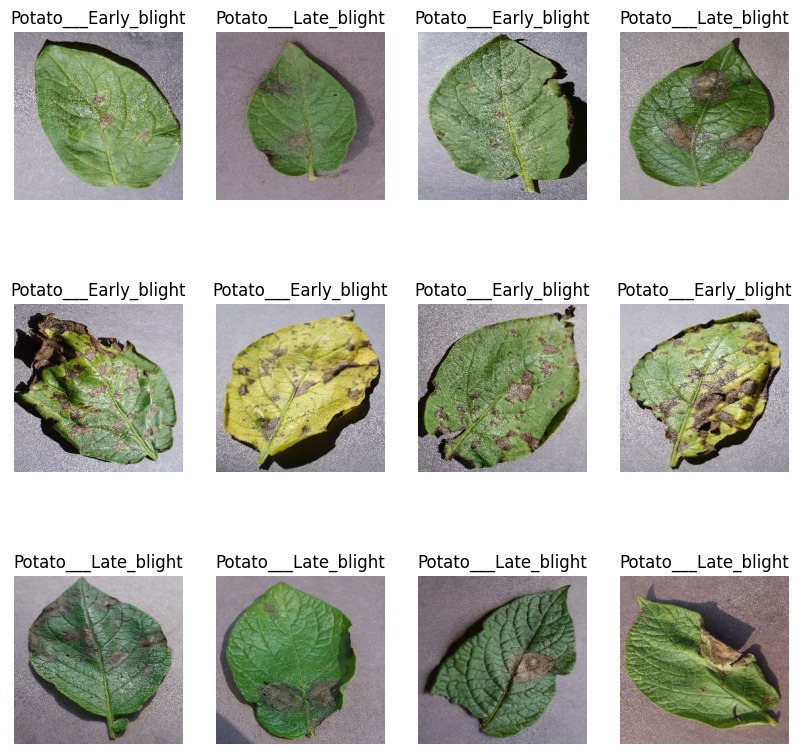

In [14]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        #have to convert float->int
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.axis("off") #remove axis
        plt.title(class_names[label_batch[i]]) #display which class it belongs

## Spliting the dataset
* Training -> 80%
* Validation -> 10% (Done after each Epoch)
* Test -> 10% (Done after model is completed)

In [23]:
train_size = 0.8
val_size = 0.1
test_size = 0.1

train_ds = dataset.take(round(len(dataset)*train_size)) #54
remain_ds = dataset.skip(round(len(dataset)*train_size)) #14
val_ds = remain_ds.take(round(len(dataset)*val_size)) #7
test_ds = remain_ds.skip(round(len(dataset)*val_size)) #7

In [24]:
#function to split
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) #to reproduce results

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [25]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [26]:
len(train_ds)

54

In [27]:
len(val_ds)

6

In [28]:
len(test_ds)

8

In [29]:
#cache a dataset, either in memory or on local storage
#prefetch will optimize by using cpu to prefetch next batch while gpu is training the current batch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Data preprocessing

In [31]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])